In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os
import string
import plotly.express as px
from pathlib import Path
from datetime import datetime
from babel.dates import format_datetime
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import nltk
import gensim
from gensim.models import CoherenceModel
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import calendar
from nltk.util import ngrams
from nltk.util import bigrams
from nltk.util import trigrams
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
import pyLDAvis.gensim_models as gensimvis

In [309]:
import pandas as pd
import numpy as np

import pickle as pk

import warnings
warnings.filterwarnings("ignore")


from bs4 import BeautifulSoup
import unicodedata
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords


from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import ne_chunk

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud

**Our objective here to create a models that able to classified a topic to data we collect from scrapping, here are the possible sequence on what we should do:**

* Text Preprocessing : this include cleaning the dataset from noise such as punctuation, stop words, as well doing stemming or lemmatization to the text

* Bag of words : process of creating a dictionary of unique words from the corpus and unique integer IDs that are used to represent those words in the LDA model. 

* Corpus : involves creating a list of bag-of-words vectors, where each vector corresponds to a document in the corpus. 

* Train the models : here we using LDA to generate our models

* Evaluate : which include understanding what topics able to tell us if there is meaning in it, usually evaluating the quality of the topics extracted, using metrics by using Coherence or perplexity technique

* Inference : applied the models to the inference dataset

# Import dataset

In [310]:
path = 'C:/Users/WINDOWS 10/Documents/Skripsi/scrapingFIX' #/FIXCSV
li = []

for file in Path(path + '/FIXCSV').glob('*.csv'):
    li.append(pd.read_csv(file))

df = pd.concat(li, axis=0, ignore_index=True)

In [311]:
df_train = df.copy()

In [312]:
df_train['tahun'] = df_train['date'].str.split().str[-1]

In [ ]:
df_train['bulan'] = df_train['date'].str.split().str[1]

# Create Text Prepocessing Function

### Stemmer

In [314]:
stemmer = StemmerFactory().create_stemmer()
stemmer2 = MPStemmer()

### Stopword 

NLTK

In [324]:
#add newstopword
stopword = stopwords.words('indonesian')
more_stopword = ['dok','dokter','selamat','halo','hallo','hi','alodokter',
                 'tadi','terus','nya','lalu','apa','jadi','bahkan','iya',
                 'kira','terimakasih','Dokter','Dok', 'langsung ',
                 'minggu', 'malam', 'siang', 'kali', 'sebab','alami', 
                 'pagi','kadang','mohon', 'terima','kasih','siang','sore','malam','pagi','alo','apa','semalam',
                 'tanggal','umur','tahun','bulan','hari','jam','minggu','kali','kemarin','kemaren','kemarinnya','kemarennya',
                 'apa','hari','bulan','tahun','jam','kali','minggu','kemarin','kemaren','kemarinnya','kemarennya','kemarin',
                 'jan','feb','mar','apr','mei','jun','jul','agu','sep','okt','nov','des','januari',
                 'februari','maret','april','mei','juni','juli','agustus','september','oktober','november',
                 'desember','sebelah','samping','sampingnya','sebelahnya','samping','sampingnya',
                 'sebelahnya','warna','ciri','assalamualaikum','wr','wb','wassalamualaikum','assalamu','alaikum','assalamualaikum']
stopword.extend(more_stopword)
not_stopword = {'capek','dpt'}
#fix stopword
fin_stp = set([word for word in stopword if word not in not_stopword])

In [316]:
# sastrawi stopword
stop_word2 = StopWordRemoverFactory()
data_stp2 = stop_word2.get_stop_words() + more_stopword

In [317]:
data_stp2.remove('tidak')
data_stp2.remove('ya')

In [318]:
final_stopword2 = StopWordRemover(ArrayDictionary(data_stp2))

### Slang ke baku

In [319]:
#slang word
baku = pd.read_csv(path + '/baku/baku[ori].csv')

std_word_replace = {}
for i, row in enumerate(baku['slang']):
    std_word_replace[row] = baku['baku'].iloc[i]

## Function

In [320]:
from gensim.utils import tokenize

## trial&error

# 2018

## EDA

In [321]:
df_2018 = df_train[df_train['tahun'] == '2018'].reset_index(drop=True)

In [322]:
#map for datetime format
bulan_map = {'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4, 'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12}
df_2018['bulan'] = df_2018['bulan'].map(bulan_map)

In [323]:
# datetime format
order_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_2018['bulan'] = df_2018['bulan'].apply(lambda x: calendar.month_name[x])
df_2018['bulan'] = pd.Categorical(df_2018['bulan'], categories=order_month, ordered=True)

In [ ]:
#explore the data
c18 = df_2018.groupby(by=['bulan']).size().reset_index(name='jumlah')
fig18 = px.line(c18, x='bulan', y='jumlah', title='Jumlah Keluhan Kesehatan Tahun 2018', markers=True)
fig18.update_layout(xaxis_title='Bulan', yaxis_title='Total', plot_bgcolor="white")
fig18.update_xaxes(tickangle=45)
fig18.update_yaxes(tickformat=',d')
fig18.show()

## Text Preprocessing

In [ ]:
df_2018.isnull().sum()

title        0
question     3
user_name    4
user_type    0
date         0
link         0
tahun        0
bulan        0
dtype: int64

In [ ]:
df_2018 = df_2018.dropna().reset_index(drop=True)

In [ ]:
#training section
df_train18 = df_2018[['title', 'question']]

### Corpus normalization

In [ ]:
#cleaning method

def remove_punct(text):
    if isinstance(text, float):
        return text
    text = text.lower()

    # Remove punctuation and digits
    text = text.replace(',', ' ')
    text = re.sub(r'[{}{}]'.format(string.punctuation, string.digits + '\n'), ' ', text)
    text = ''.join('' if a in string.punctuation + string.digits else a for a in text)
    return text

def dok_word(text):
    text = remove_punct(text)
    split_dok = text.split()
    for i, word in enumerate(split_dok):
        if word.startswith('dok') and len(word) > 3:
            split_dok[i] = 'dok' + word.replace('dok', '', 1)
    text = " ".join(split_dok)
    return text

def normalization(text):
    text = dok_word(text)
    temp_list = []
    temp_normalization = text.split()
    for i in temp_normalization:
        if i not in std_word_replace:
            temp_list.append(i)
        elif i in std_word_replace:
            temp_list += std_word_replace[i].split()
    temp_list = ' '.join(text for text in temp_list if text not in fin_stp)
    return temp_list

def token_funct(text):
    text = list(normalization(text).split(" "))
    return text

In [ ]:
df_train18['clean'] = df_train18['question'].apply(lambda x: token_funct(x))

### n-gram


In [ ]:
def make_bigrams(texts): #fungsi untuk membuat bigram
    bigram = gensim.models.Phrases(texts, min_count=1) #hyperparameter untuk penentuan bobot perkata
    bigram_mod = gensim.models.phrases.Phraser(bigram) #pembentukan model
    return [bigram_mod[doc] for doc in texts] #hasil kata-kata yang tercipta menggunakan model

bigrams18 = make_bigrams(df_train18['clean'])

In [ ]:
def trigram_func(texts): #fungsi untuk membuat trigram
    bigram = gensim.models.Phrases(texts, min_count=1)
    trigram = gensim.models.Phrases(bigram[texts], min_count =1, threshold=1)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[doc] for doc in texts]

trigrams18 = trigram_func(df_train18['clean'])

a few details about the threshold parameter:

This parameter is used by the estimator to determine if two words a and b form a phrase, and that is only if:

(count(a followed by b) - min_count) * N/(count(a) * count(b)) > threshold
where N is the total vocabulary size. By default the parameter value is 10 (see docs). So, the higher the threshold, the harder the constraints for words to form phrases.

For example, in your first approach you were trying to use threshold = 1, so you would get ['human computer','interaction is'] as digrams of 3 out of your 5 sentences that begin with "human computer interaction"; that weird second digram is a result of the more relaxed threshold.

Then, when you try to get trigrams with default threshold = 10 you only get ['human computer interaction is'] for those 3 sentences, and nothing for the remaining two (filtered by threshold); and because that was a 4-gram instead of a trigram it would also be filtered by if t.count(' ') == 2. In case that, for example, you lower the trigram threshold to 1, you can get ['human computer interaction'] as trigram for the two remaining sentences. It doesn't seem easy to get a good combination of parameters, here's more about it.

I'm not an expert, so take this conclusion with a grain of salt: I think it's better to firstly get good digram results (not like 'interaction is') before moving on, as weird digrams can add confusion to further trigrams, 4-gram...

https://stackoverflow.com/questions/46148182/issues-in-getting-trigrams-using-gensim

In [ ]:
bigrams = [bigram for doc in bigrams18 for bigram in doc if '_' in bigram]
trigrams = [trigram for doc in trigrams18 for trigram in doc if '_' in trigram]

def visualize_frequent_words(tokens_list, num_words):
    # Count the frequency of each token
    word_freq = Counter(tokens_list)
    
    # Get the most frequent words
    top_words = word_freq.most_common(num_words)
    
    # Extract the words and their counts
    words = [w[0] for w in top_words]
    counts = [w[1] for w in top_words]
    
    # Create a bar chart of the word frequencies
    figure = px.bar(x=words, y=counts, title='Top {} Most Frequent Words'.format(num_words))
    figure.update_layout(xaxis_title='Word', yaxis_title='Frequency', plot_bgcolor="white")
    figure.update_xaxes(tickangle=45)
    figure.update_yaxes(tickformat=',d')
    figure.show()

In [ ]:
visualize_frequent_words(bigrams, 20)

In [ ]:
visualize_frequent_words(trigrams, 20)

#### use it when needed

In [ ]:
token_toremove = ['terima_kasih','kasih','sebab',
                  'terima','tanggal','hari','teman',
                  'bulan','kah', 'maaf','trimakasih',
                  'assalamualaikum', 'jelas_terima', 
                  'atas_terima', 'hello', 'ku', 'doc', 
                  'trimakasi', 'trkadang', 'skrg', 
                  'jelas','cek', 'kemarin', 'apakh', 
                  'sok', 'tanya', 'ig', 'cerita', 'biar', 
                  'pakai', 'laku', 'saran', 'ada', 'nomor', 
                  'sih', 'suka', 'selsai', 'minggu', 'tunggu', 
                  'keluar', 'solusi', 'alami', 'apa', 'tolong', 'kena',
                  'salah', 'orang', 'beda', 'coba', 'batch', 
                  'amadeo_basfiansa', 'ianya', 
                  'dlakukan', 'maksud', 'kesan', 'deh', 'and', 
                  'tanyak', 'nak', 'nyri', 'ubat', 'rana', 'aqua',
                  'assalamu_alaikum', 'hai_brtanya', 'gara', 'uk', 'terima_kasih_kasih', 
                  'smacam', 'nama', 'now_watching', 'tolong_solusi_terima_kasih','tgl',
                  'atas_terima_kasih','ass','tolong_jelas','tolong_jelas','nanyak',
                  'wass', 'jawabanya_terima_kasih', 'doctor', 'doktor', 'hai', 'terimakasi', 
                  'misi', 'kemarin_habis', 'tnykn', 'dokk', 'hai_doktor', 'berak_dokk', 'jam', 
                  'sore', 'umur' ,'sakit', 'sembuh', 'usia', 'kayak', 'knapa', 'terima_kasih_sukses', 
                  'sekian_terima_kasih', 'umur_alami', 'assalamu_alaikum_nama', 'ter',
                  'ter_bedah','apa_apa','tanggal','trmksh','maaf_mengganggu','dampaknya',
                  'berbahayakah','penyebab_mengatasinya',
                  'adakah','pengin','sehabis','stlah','mengalami','gejala','merasakan','informasi',
                  'pemeriksaan','penyebabnya_solusinya',
                  'penyebab','assalamu','numpang','nnya','asalamualaikum','kenpa','tolong_penjelasan',
                  'kira²','mencegahnya','tolong_informasi',
                  'alasannya','pertamanya','sayakan','minum_obat','minum','now_watching',
                  'berobat','moga','periksa', 'haid_haid','assalamualaikum_wr','wr_wb']
for i, doc in enumerate(trigrams18):
    trigrams18[i] = [token for token in doc if token != token_toremove]

In [ ]:
target_word = 'assalamualaikum_wr'
found_tokens = []

for doc in trigrams18:
    for token in doc:
        if token == target_word:
            found_tokens.append(token)

print(found_tokens)

In [ ]:
filtered_token = [[token for token in doc if token not in token_toremove] for doc in trigrams18]

### Most Frequent word

In [ ]:
# check removed token
word_freq19 = Counter([item for sublist in filtered_token for item in sublist])
word_freq19.most_common(10)

[('obat', 6168),
 ('anak', 4148),
 ('normal', 2884),
 ('darah', 2543),
 ('hamil', 2416),
 ('makan', 2051),
 ('nyeri', 2022),
 ('hilang', 1996),
 ('bahaya', 1931),
 ('atas', 1865)]

In [ ]:
#check most frequent words
all_words = [word for tokens in df_train18['clean'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_train18['clean']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1185720 words total, with a vocabulary size of 44389
Max sentence length is 566


In [ ]:
word_freq = Counter(all_words)
word_freq.most_common(10)

[('sakit', 33353),
 ('obat', 21175),
 ('anak', 11588),
 ('minum', 10514),
 ('darah', 10317),
 ('makan', 9240),
 ('hamil', 8186),
 ('alami', 8080),
 ('usia', 7783),
 ('perut', 7694)]

## Dictionary from the corpus

## Create corpus to input to the models

In [ ]:
#create dict
dictionary18 = corpora.Dictionary(filtered_token)
#create corpus
texts = filtered_token
corpus18 = [dictionary18.doc2bow(text) for text in texts]   

In [ ]:
def dict_function(text):
    dictionary = corpora.Dictionary(text)
    return dictionary


dictionary_input = dict_function(filtered_token)
dictionary_input.token2id

{'anak_imunisasi': 0,
 'bekas_suntik': 1,
 'bengkak': 2,
 'bengkak_merah': 3,
 'efektif': 4,
 'hangat': 5,
 'kompres_air': 6,
 'p': 7,
 'sayang': 8,
 'trombop': 9,
 'dengar': 10,
 'keras_suara': 11,
 'olah': 12,
 'orang_dengar': 13,
 'suara_dengar': 14,
 'telinga_sakit': 15,
 'volume_suara': 16,
 'asam_lambung': 17,
 'gejala_hamil': 18,
 'habis_makan': 19,
 'haid': 20,
 'haid_hubung': 21,
 'hamil_rasa': 22,
 'intim_langsung': 23,
 'kepala_pusing': 24,
 'lelah': 25,
 'mag': 26,
 'meni_usia': 27,
 'putih': 28,
 'rina': 29,
 'sakit_maag': 30,
 'suka_mual': 31,
 'badan_lemas': 32,
 'doj': 33,
 'insomnia_tidur': 34,
 'susah_tidur': 35,
 'bahan': 36,
 'biotin': 37,
 'efek_samping': 38,
 'gen': 39,
 'kekurangen': 40,
 'konsumsi_biotin': 41,
 'label': 42,
 'mcg': 43,
 'tulis_aman': 44,
 'tumbuh_rambut': 45,
 'aman': 46,
 'bada': 47,
 'efek': 48,
 'imbang_olahraga': 49,
 'konsumsi_suplemen': 50,
 'pegal_pegal': 51,
 'perempuan': 52,
 'punggung': 53,
 'rahma': 54,
 'tambah_badan': 55,
 'tulang':

In [ ]:
def corpus_document(text):
    dictionary = dict_function(text)
    corpus = [dictionary.doc2bow(text) for text in text]
    return corpus

In [ ]:
def corpus_document(text):
    dictionary = dict_function(text)
    corpus = [dictionary.doc2bow(text) for text in text]
    return corpus

corpora_input = corpus_document(filtered_token)

In [ ]:
corpora_input

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)],
 [(17, 2),
  (18, 2),
  (19, 1),
  (20, 2),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1)],
 [(24, 1), (32, 1), (33, 1), (34, 1), (35, 1)],
 [(36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2)],
 [(46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1)],
 [(57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1)],
 [(69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1)],
 [(90, 1), (91, 1), (

LDA modeling, you need two inputs: the document-term matrix and the number of topics to be extracted. The document-term matrix represents the frequency of occurrence of each word in the corpus, while the number of topics is the hyperparameter that needs to be specified beforehand.

In the case of Gensim's LdaModel, you also need to provide the dictionary mapping words to their integer ids as an input. This dictionary is usually created from the corpus using Gensim's Dictionary function.

However, some LDA implementations in other libraries might have different input requirements.

## Train the models

here a possible sequence that we use to create a models which include checking how good the modesl is by addapting coherence value inside of the function

In [ ]:
import multiprocessing

print(f"Number of CPU cores: {multiprocessing.cpu_count()}")

Number of CPU cores: 8


In [ ]:
def model_LDA(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list1 = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=42,
                        chunksize=5,
                        passes=20,
                        update_every=5,
                        alpha=0.8,
                        eta=0.5,
                        decay=0.8,
                        iterations=150,
                        minimum_probability=0.1,
                        per_word_topics=True) 
        model_list1.append(model) 

        #check the coherence value

        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts,
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        #check the preplexity
        
        perplexity = model.log_perplexity(corpus)

    return model_list1, coherence_values, perplexity

It is important that changing the hyperparameters can have trade-offs. Increasing alpha can lead to more diverse topics, but it can also increase the noise in the topics. Decreasing eta can lead to more diverse words within topics, but it can also lead to more similar topics. Therefore, it is recommended to try different values of hyperparameters and evaluate the resulting topics based on coherence and interpretability.

In [ ]:
def model_LDA(dictionary, corpus, limit, start, step):

    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics, 
                        random_state=63,
                        chunksize=10,
                        passes=20,
                        update_every=3,
                        alpha='auto',
                        eta='auto',
                        decay=0.8,
                        iterations=150,
                        minimum_probability=0.02,
                        per_word_topics=True) 
        model_list.append(model) 
    return model_list

In [ ]:
def coherences_score(model,text,dictionary):
    coherence_values = []
    for i in model:
        coherence_model = CoherenceModel(model=i, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)
    return coherence_values

coh = coherences_score(model_list, filtered_token, dictionary_input)

In [ ]:
def preplexity_score(model,corpus):
    perplexity_values = []
    for i in model:
        perplexity = i.log_perplexity(corpus)
        perplexity_values.append(perplexity)
    return perplexity_values

perp = preplexity_score(model_list,corpora_input)

In [ ]:
perp

[-9.908578435521454,
 -9.993057624450465,
 -10.120942178472879,
 -10.16851485918361,
 -10.305114788061195,
 -10.405253984732209,
 -10.505092320575537,
 -10.57329481958138]

In [ ]:
model_list, coherence_values, preplexity = model_LDA(dictionary=dictionary18, corpus=corpus18, texts=filtered_token, start=2, limit=18, step=2) 

In [ ]:
for i in model_list:
    topics = i.show_topics()
    for topic_id, topic_words in topics:
        print(f"Topic {topic_id}: {topic_words}")
    print("----------------------")

Topic 0: 0.008*"obat" + 0.004*"hilang" + 0.004*"nyeri" + 0.004*"tangan" + 0.003*"mata" + 0.003*"gatal" + 0.003*"kanan" + 0.003*"atas" + 0.003*"kiri" + 0.003*"operasi"
Topic 1: 0.011*"anak" + 0.007*"hamil" + 0.006*"obat" + 0.005*"darah" + 0.005*"haid" + 0.005*"normal" + 0.004*"makan" + 0.003*"bayi" + 0.003*"perut" + 0.003*"buang_air"
----------------------
Topic 0: 0.010*"obat" + 0.006*"operasi" + 0.006*"tangan" + 0.006*"gatal" + 0.005*"hilang" + 0.005*"kulit" + 0.004*"kaki" + 0.004*"kepala" + 0.004*"gigi" + 0.004*"bengkak"
Topic 1: 0.018*"anak" + 0.011*"hamil" + 0.008*"haid" + 0.007*"darah" + 0.005*"bayi" + 0.005*"normal" + 0.004*"suami" + 0.003*"anak_usia" + 0.003*"putih" + 0.003*"bahaya"
Topic 2: 0.008*"nyeri" + 0.007*"obat" + 0.007*"makan" + 0.006*"mata" + 0.005*"benjol" + 0.005*"kanan" + 0.005*"perut" + 0.004*"kiri" + 0.004*"rasa" + 0.004*"demam"
Topic 3: 0.006*"obat" + 0.005*"normal" + 0.004*"berat_badan" + 0.004*"hasil" + 0.003*"konsumsi" + 0.003*"turun" + 0.003*"takut" + 0.002*"

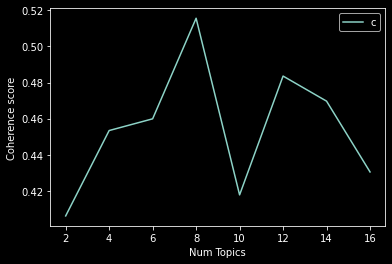

In [ ]:
# show graph
limit=18; start=2; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
bm_1 = coherence_values.index(max(coherence_values))
bm_2 = model_list[bm_1]
bm_1

3

In [ ]:
bm_2.show_topics()

[(0,
  '0.006*"sakit_kepala" + 0.006*"rasa" + 0.005*"obat" + 0.005*"kepala" + 0.005*"demam" + 0.005*"tidur" + 0.005*"pusing" + 0.005*"batuk" + 0.004*"bangun_tidur" + 0.004*"sakit_perut"'),
 (1,
  '0.034*"obat" + 0.029*"anak" + 0.009*"makan" + 0.009*"bayi" + 0.008*"anak_usia" + 0.007*"berat_badan" + 0.006*"konsumsi" + 0.005*"susu" + 0.005*"efek_samping" + 0.004*"bab"'),
 (2,
  '0.009*"operasi" + 0.009*"benjol" + 0.009*"nyeri" + 0.008*"bengkak" + 0.008*"kanan" + 0.006*"kiri" + 0.006*"gigi" + 0.006*"tangan" + 0.004*"kaki" + 0.004*"bahaya"'),
 (3,
  '0.011*"hasil" + 0.006*"normal" + 0.004*"darah" + 0.003*"cek_darah" + 0.002*"tes" + 0.002*"hiv" + 0.002*"hasil_lab" + 0.002*"negatif" + 0.002*"paru" + 0.002*"tunjuk"'),
 (4,
  '0.006*"takut" + 0.005*"tubuh" + 0.004*"pikir" + 0.004*"rumah" + 0.004*"milik" + 0.003*"orang_tua" + 0.003*"bilang" + 0.003*"tidur" + 0.003*"sadar" + 0.003*"adik"'),
 (5,
  '0.011*"mata" + 0.011*"gatal" + 0.007*"hilang" + 0.007*"kulit" + 0.006*"merah" + 0.005*"luka" + 0.0

In [ ]:
best_model = model_list[np.argmax(coherence_values)]
best_model.print_topics()

[(0,
  '0.006*"sakit_kepala" + 0.006*"rasa" + 0.005*"obat" + 0.005*"kepala" + 0.005*"demam" + 0.005*"tidur" + 0.005*"pusing" + 0.005*"batuk" + 0.004*"bangun_tidur" + 0.004*"sakit_perut"'),
 (1,
  '0.034*"obat" + 0.029*"anak" + 0.009*"makan" + 0.009*"bayi" + 0.008*"anak_usia" + 0.007*"berat_badan" + 0.006*"konsumsi" + 0.005*"susu" + 0.005*"efek_samping" + 0.004*"bab"'),
 (2,
  '0.009*"operasi" + 0.009*"benjol" + 0.009*"nyeri" + 0.008*"bengkak" + 0.008*"kanan" + 0.006*"kiri" + 0.006*"gigi" + 0.006*"tangan" + 0.004*"kaki" + 0.004*"bahaya"'),
 (3,
  '0.011*"hasil" + 0.006*"normal" + 0.004*"darah" + 0.003*"cek_darah" + 0.002*"tes" + 0.002*"hiv" + 0.002*"hasil_lab" + 0.002*"negatif" + 0.002*"paru" + 0.002*"tunjuk"'),
 (4,
  '0.006*"takut" + 0.005*"tubuh" + 0.004*"pikir" + 0.004*"rumah" + 0.004*"milik" + 0.003*"orang_tua" + 0.003*"bilang" + 0.003*"tidur" + 0.003*"sadar" + 0.003*"adik"'),
 (5,
  '0.011*"mata" + 0.011*"gatal" + 0.007*"hilang" + 0.007*"kulit" + 0.006*"merah" + 0.005*"luka" + 0.0

In [ ]:
best_model

In [ ]:
vis = pyLDAvis.gensim_models.prepare(best_model, corpus18, dictionary18)
vis_html = pyLDAvis.prepared_data_to_html(vis)
vis_html = vis_html.replace('width: 100%;', 'width: 800px;')  # Set the width
vis_html = vis_html.replace('height: 100%;', 'height: 600px;')  # Set the height

# Save the modified visualization to an HTML file
pyLDAvis.save_html(vis, 'C:/Users/WINDOWS 10/Documents/Skripsi/scrapingFIX/output.html')

Topic modeling and TF-IDF are both techniques commonly used in natural language processing (NLP), but they serve different purposes.

Topic modeling is a method used to extract the underlying topics or themes from a large collection of text documents. It is an unsupervised learning technique that identifies the topics present in the text data by analyzing the frequency of words and their co-occurrence patterns across the documents. Commonly used topic modeling algorithms include Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF).

TF-IDF, on the other hand, is a method used to identify the most important words or terms in a single document. It stands for Term Frequency-Inverse Document Frequency, and it assigns a weight to each term in a document based on how often it appears in the document (term frequency) and how important it is across all the documents in the corpus (inverse document frequency). TF-IDF is commonly used for text classification, information retrieval, and search engine optimization.

In summary, topic modeling is used to extract the underlying themes or topics from a collection of documents, while TF-IDF is used to identify the most important terms in a single document.

In [ ]:
#show perplexity
print(f"Perplexity: {best_model.log_perplexity(corpus18)}")

Perplexity: -10.168514856493424


In [ ]:
import math
nbound = np.exp2(best_model.log_perplexity(corpus18))
print(f"Perplexity: {nbound}")

Perplexity: 0.0008689044407894748


### Inference Test

In [ ]:
inference = "Alodokter,,,,, saya ingin bertanya sudah beberapa hari ini saya sakit punggung sebelah atas tepatnya dibelakang jantung. Akan terasa sakit apa lagi saat saya lagi membungkuk kalao posisi lurus agak berkurang sakitny. Ini sebenernya saya sakit apa sih dok? obatnya pake apa ya? perlu gak sih dok memeriksakan lebih lanjut.? apa ini normal2 aja?"

In [ ]:
inference_token = list(token_funct(inference))

In [ ]:
inference_token1 = [inference_token]

In [ ]:
inference_token1

[['sakit',
  'punggung',
  'tepat',
  'belakang',
  'jantung',
  'sakit',
  'bungkuk',
  'kalao',
  'posisi',
  'lurus',
  'kurang',
  'sakitny',
  'sakit',
  'sih',
  'obat',
  'pakai',
  'sih',
  'periksa',
  'normal']]

In [ ]:
inference_dict = dict_function(inference_token1)

In [ ]:
inference_dict

In [ ]:
inference_corpus = corpus_document(inference_token1)

In [ ]:
inference_corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 3),
  (13, 1),
  (14, 2),
  (15, 1)]]

In [ ]:
inference_model = [best_model.get_document_topics(item) for item in inference_corpus]

In [ ]:
inf_model = bm_2[inference_corpus]

In [ ]:
for o in inf_model:
    print(o)

([(0, 0.11063408), (2, 0.15993123), (4, 0.44627538)], [(0, [1, 4]), (1, [4, 2, 7]), (2, [2, 5]), (3, [2, 5, 4]), (4, [4, 5]), (5, [0, 5, 2, 1]), (6, [2, 5, 0]), (7, [1, 4, 3, 7, 5]), (8, [4, 2, 5, 0, 7, 1]), (9, [4, 2, 1, 5, 0, 6, 3, 7]), (10, [4]), (11, [4, 0, 2]), (12, [4]), (13, [4, 0, 2, 1]), (14, [4, 0, 2]), (15, [0])], [(0, [(1, 0.9712358), (4, 0.014750588)]), (1, [(2, 0.46868265), (4, 0.47580543), (7, 0.012665948)]), (2, [(2, 0.9610002), (5, 0.037721734)]), (3, [(2, 0.51825494), (4, 0.016112298), (5, 0.4535653)]), (4, [(4, 0.95392585), (5, 0.03170044)]), (5, [(0, 0.5955024), (1, 0.070500456), (2, 0.081657834), (5, 0.24451005)]), (6, [(0, 0.021270618), (2, 0.8118437), (5, 0.1541494)]), (7, [(1, 0.3133681), (3, 0.21535777), (4, 0.22369215), (5, 0.077286884), (7, 0.14801134)]), (8, [(0, 0.02637308), (1, 0.0132022705), (2, 0.12828515), (4, 0.7796624), (5, 0.026827006), (7, 0.019453313)]), (9, [(0, 0.04938811), (1, 0.07044161), (2, 0.18528797), (3, 0.02507644), (4, 0.4815422), (5, 0.

In [ ]:
inf_model

In [ ]:
inference_model

[[(0, 0.11063736), (2, 0.15994298), (4, 0.4462736)]]

In [ ]:
for i, inference in enumerate(inference_model):
    print(f"Inference for document {i}:")
    for topic, prob in inference:
        print(f"Topic {topic}: {prob:.4f}")
    print()

Inference for document 0:
Topic 0: 0.1106
Topic 2: 0.1599
Topic 4: 0.4463



In [ ]:
# Convert the TransformedCorpus object to a list of tuples
inference_result = list(inference_model)

# Iterate over the inference result
for document in inference_result:
    # Access the document-topic distribution
    document_topic_distribution = document[0]

    # Access the top-N topics in the document
    top_n_topics = document[1]

    # Access the word-topic distributions in the document
    word_topic_distributions = document[2]

    # Process the document-topic distribution, top-N topics, and word-topic distributions
    print(f"Document-topic distribution: {document_topic_distribution}")
    print(f"Top-N topics: {top_n_topics}")


Document-topic distribution: (0, 0.11063736)
Top-N topics: (2, 0.15994298)


In [ ]:
topics = bm_2.show_topics(formatted=False)
topics

[(0,
  [('sakit_kepala', 0.005946838),
   ('rasa', 0.005584657),
   ('obat', 0.005450755),
   ('kepala', 0.005030315),
   ('demam', 0.004859824),
   ('tidur', 0.004851499),
   ('pusing', 0.0046281554),
   ('batuk', 0.0045946417),
   ('bangun_tidur', 0.0043158308),
   ('sakit_perut', 0.004129377)]),
 (1,
  [('obat', 0.034303702),
   ('anak', 0.029157503),
   ('makan', 0.00909984),
   ('bayi', 0.008654734),
   ('anak_usia', 0.007547381),
   ('berat_badan', 0.007397383),
   ('konsumsi', 0.005815053),
   ('susu', 0.005121898),
   ('efek_samping', 0.00492284),
   ('bab', 0.004130895)]),
 (2,
  [('operasi', 0.009450602),
   ('benjol', 0.00896526),
   ('nyeri', 0.008806554),
   ('bengkak', 0.008414645),
   ('kanan', 0.008334596),
   ('kiri', 0.006261875),
   ('gigi', 0.0061009405),
   ('tangan', 0.0055105044),
   ('kaki', 0.004456246),
   ('bahaya', 0.004264799)]),
 (3,
  [('hasil', 0.011171723),
   ('normal', 0.0057325107),
   ('darah', 0.003541342),
   ('cek_darah', 0.002520705),
   ('tes',

In [ ]:
data = []
for topic_id, topic in topics:
    for word_prob in topic:
        word = word_prob[0]
        probability = word_prob[1]
        data.append({'Topic': topic_id, 'Word': word, 'Probability': probability})

df_topics = pd.DataFrame(data)

# Sort the dataframe by topic and probability in descending order
df_topics = df_topics.sort_values(['Topic', 'Probability'], ascending=[True, False])

# Print the dataframe
df_topics

,Topic,Word,Probability
0,0,sakit_kepala,0.005947
1,0,rasa,0.005585
2,0,obat,0.005451
3,0,kepala,0.005030
4,0,demam,0.004860
...,...,...,...
75,7,buang_air,0.005236
76,7,hubung_intim,0.004468
77,7,putih,0.004442
78,7,kandung,0.004386


In [ ]:
topic_words = {}
for topic_id, topic in topics:
    words = [word_prob[0] for word_prob in topic]
    probabilities = [word_prob[1] for word_prob in topic]
    topic_words[topic_id] = words + probabilities

# Create the dataframe using the topic words dictionary
df_topics = pd.DataFrame.from_dict(topic_words, orient='index').reset_index()
df_topics.columns = ['Topic'] + ['Word {}'.format(i) for i in range(1, len(df_topics.columns))]

# Print the dataframe
df_topics

,Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
0,0,sakit_kepala,rasa,obat,kepala,demam,tidur,pusing,batuk,bangun_tidur,...,0.005947,0.005585,0.005451,0.005030,0.004860,0.004851,0.004628,0.004595,0.004316,0.004129
1,1,obat,anak,makan,bayi,anak_usia,berat_badan,konsumsi,susu,efek_samping,...,0.034304,0.029158,0.009100,0.008655,0.007547,0.007397,0.005815,0.005122,0.004923,0.004131
2,2,operasi,benjol,nyeri,bengkak,kanan,kiri,gigi,tangan,kaki,...,0.009451,0.008965,0.008807,0.008415,0.008335,0.006262,0.006101,0.005511,0.004456,0.004265
3,3,hasil,normal,darah,cek_darah,tes,hiv,hasil_lab,negatif,paru,...,0.011172,0.005733,0.003541,0.002521,0.002482,0.002215,0.002189,0.002148,0.002019,0.002006
4,4,takut,tubuh,pikir,rumah,milik,orang_tua,bilang,tidur,sadar,...,0.006102,0.005230,0.004332,0.003964,0.003641,0.003448,0.003319,0.003286,0.002950,0.002845
5,5,mata,gatal,hilang,kulit,merah,luka,air,kering,atas,...,0.010765,0.010545,0.007241,0.006675,0.006437,0.005334,0.005176,0.003589,0.003426,0.003391
6,6,mama,wb,mandi,kejang,assalamualaikum_wr,ciri_ciri,kamar_mandi,wr_wb,laki,...,0.003968,0.003287,0.003133,0.002445,0.002266,0.001721,0.001492,0.001419,0.001195,0.001165
7,7,hamil,haid,darah,suami,normal,buang_air,hubung_intim,putih,kandung,...,0.015235,0.011463,0.009766,0.005624,0.005365,0.005236,0.004468,0.004442,0.004386,0.003972


In [ ]:
topic_data = []
for topic_id, topic in topics:
    words = [word_prob[0] for word_prob in topic]
    probabilities = [word_prob[1] for word_prob in topic]
    merged_data = [f'{word} ({prob:.4f})' for word, prob in zip(words, probabilities)]
    topic_data.append([topic_id] + merged_data)

# Create the dataframe using the topic data
df_topics = pd.DataFrame(topic_data, columns=['Topic'] + ['Word & Probability'] * len(words))

# Print the dataframe
df_topics

,Topic,Word & Probability,Word & Probability,Word & Probability,Word & Probability,Word & Probability,Word & Probability,Word & Probability,Word & Probability,Word & Probability,Word & Probability
0,0,sakit_kepala (0.0059),rasa (0.0056),obat (0.0055),kepala (0.0050),demam (0.0049),tidur (0.0049),pusing (0.0046),batuk (0.0046),bangun_tidur (0.0043),sakit_perut (0.0041)
1,1,obat (0.0343),anak (0.0292),makan (0.0091),bayi (0.0087),anak_usia (0.0075),berat_badan (0.0074),konsumsi (0.0058),susu (0.0051),efek_samping (0.0049),bab (0.0041)
2,2,operasi (0.0095),benjol (0.0090),nyeri (0.0088),bengkak (0.0084),kanan (0.0083),kiri (0.0063),gigi (0.0061),tangan (0.0055),kaki (0.0045),bahaya (0.0043)
3,3,hasil (0.0112),normal (0.0057),darah (0.0035),cek_darah (0.0025),tes (0.0025),hiv (0.0022),hasil_lab (0.0022),negatif (0.0021),paru (0.0020),tunjuk (0.0020)
4,4,takut (0.0061),tubuh (0.0052),pikir (0.0043),rumah (0.0040),milik (0.0036),orang_tua (0.0034),bilang (0.0033),tidur (0.0033),sadar (0.0030),adik (0.0028)
5,5,mata (0.0108),gatal (0.0105),hilang (0.0072),kulit (0.0067),merah (0.0064),luka (0.0053),air (0.0052),kering (0.0036),atas (0.0034),wajah (0.0034)
6,6,mama (0.0040),wb (0.0033),mandi (0.0031),kejang (0.0024),assalamualaikum_wr (0.0023),ciri_ciri (0.0017),kamar_mandi (0.0015),wr_wb (0.0014),laki (0.0012),sunti (0.0012)
7,7,hamil (0.0152),haid (0.0115),darah (0.0098),suami (0.0056),normal (0.0054),buang_air (0.0052),hubung_intim (0.0045),putih (0.0044),kandung (0.0044),istri (0.0040)


In [ ]:
# Create a list to store the topic data
topic_data = []
for topic_id, topic in topics:
    words = [word_prob[0] for word_prob in topic]
    probabilities = [word_prob[1] for word_prob in topic]
    merged_data = [f'{word} ({prob:.4f})' for word, prob in zip(words, probabilities)]
    topic_data.append([topic_id] + merged_data)

# Create the dataframe using the topic data
df_topics = pd.DataFrame(topic_data, columns=['Topic'] + [f'Word_{i+1}_Probability' for i in range(len(words))])

# Print the dataframe
df_topics

,Topic,Word_1_Probability,Word_2_Probability,Word_3_Probability,Word_4_Probability,Word_5_Probability,Word_6_Probability,Word_7_Probability,Word_8_Probability,Word_9_Probability,Word_10_Probability
0,0,sakit_kepala (0.0059),rasa (0.0056),obat (0.0055),kepala (0.0050),demam (0.0049),tidur (0.0049),pusing (0.0046),batuk (0.0046),bangun_tidur (0.0043),sakit_perut (0.0041)
1,1,obat (0.0343),anak (0.0292),makan (0.0091),bayi (0.0087),anak_usia (0.0075),berat_badan (0.0074),konsumsi (0.0058),susu (0.0051),efek_samping (0.0049),bab (0.0041)
2,2,operasi (0.0095),benjol (0.0090),nyeri (0.0088),bengkak (0.0084),kanan (0.0083),kiri (0.0063),gigi (0.0061),tangan (0.0055),kaki (0.0045),bahaya (0.0043)
3,3,hasil (0.0112),normal (0.0057),darah (0.0035),cek_darah (0.0025),tes (0.0025),hiv (0.0022),hasil_lab (0.0022),negatif (0.0021),paru (0.0020),tunjuk (0.0020)
4,4,takut (0.0061),tubuh (0.0052),pikir (0.0043),rumah (0.0040),milik (0.0036),orang_tua (0.0034),bilang (0.0033),tidur (0.0033),sadar (0.0030),adik (0.0028)
5,5,mata (0.0108),gatal (0.0105),hilang (0.0072),kulit (0.0067),merah (0.0064),luka (0.0053),air (0.0052),kering (0.0036),atas (0.0034),wajah (0.0034)
6,6,mama (0.0040),wb (0.0033),mandi (0.0031),kejang (0.0024),assalamualaikum_wr (0.0023),ciri_ciri (0.0017),kamar_mandi (0.0015),wr_wb (0.0014),laki (0.0012),sunti (0.0012)
7,7,hamil (0.0152),haid (0.0115),darah (0.0098),suami (0.0056),normal (0.0054),buang_air (0.0052),hubung_intim (0.0045),putih (0.0044),kandung (0.0044),istri (0.0040)


In [307]:
topic_data = []
for topic_id, topic in topics:
    words = [word_prob[0] for word_prob in topic]
    topic_data.append([topic_id] + words)

# Create the dataframe using the topic data
df_topics = pd.DataFrame(topic_data, columns=['Topic'] + [f'Word_{i+1}' for i in range(len(words))])

# Print the dataframe
df_topics

,Topic,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
0,0,sakit_kepala,rasa,obat,kepala,demam,tidur,pusing,batuk,bangun_tidur,sakit_perut
1,1,obat,anak,makan,bayi,anak_usia,berat_badan,konsumsi,susu,efek_samping,bab
2,2,operasi,benjol,nyeri,bengkak,kanan,kiri,gigi,tangan,kaki,bahaya
3,3,hasil,normal,darah,cek_darah,tes,hiv,hasil_lab,negatif,paru,tunjuk
4,4,takut,tubuh,pikir,rumah,milik,orang_tua,bilang,tidur,sadar,adik
5,5,mata,gatal,hilang,kulit,merah,luka,air,kering,atas,wajah
6,6,mama,wb,mandi,kejang,assalamualaikum_wr,ciri_ciri,kamar_mandi,wr_wb,laki,sunti
7,7,hamil,haid,darah,suami,normal,buang_air,hubung_intim,putih,kandung,istri


In [ ]:
awdawd

-----

# FlairNLP Sequence Tagger

In [ ]:
from flair.models import SequenceTagger

In [ ]:
import torch

folder_path = "C:/Users/WINDOWS 10/Documents/Skripsi/scrapingFIX/indonesia-bioner"
model_state = torch.load(f"{folder_path}/pytorch_model.bin", map_location=torch.device('cpu'))

In [ ]:
from flair.models import SequenceTagger


tagger = SequenceTagger.load("abid/indonesia-bioner")

In [ ]:
def tag_ner(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    
    tokens = []
    for token in sentence:
        if 'DISO' in token.get_labels() or 'ANAT' in token.get_labels():
            tokens.append(token.text)
            
    return tokens

In [ ]:
df_train18

In [ ]:
from flair.data import Sentence

sentence = Sentence('Presiden Jokowi akan mengunjungi Yogyakarta minggu depan')

In [ ]:
tagger.predict(sentence)

In [ ]:
print(sentence.to_tagged_string())

In [ ]:
# iterate over the predicted named entities
for entity in sentence.get_spans('ner'):
    # get the entity type (label)
    label = entity.get_labels()[0].value
    print(f'{entity.text}: {label}')

In [ ]:
def tag_ner(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    return sentence.to_tagged_string()

In [ ]:
df_train18['ner'] = df_train18['clean'].apply(lambda x: tag_ner(x))

In [ ]:
df_train18['no_token'] = df_train18['question'].apply(lambda x: normalization(x))

In [ ]:
df_train18['ner_no_token'] = df_train18['no_token'].apply(lambda x: tag_ner(x))

In [ ]:
df_train18['ner_no_token'][213]

In [ ]:
df_train18['question'][213]

In [ ]:
df_train18['no_token'][213]

In [ ]:
df_train18['question'][5512]

In [ ]:
# define the text to be analyzed
text = 'siang dok,saya ingin bertanya,ada tmn saya menderita epilepsi sejak kelas 3 SMP sampai skrg tdk sembuh total,umurnya kira2 32 taun,sdh berbagai pengobatan tdk sembuh total,mau medis,non medis,trapi,ruqyah,bekam,obat2an.dironsen tdk mslh pd kepalanya.apa obat yg mujarab sembuhi total ya dok?? trims ya dok jwbnnya\n '

# create a Flair sentence object
sentence = Sentence(text)

# predict the entities in the sentence
tagger.predict(sentence)

# create a list of tuples (entity_text, entity_type) for each entity
entities = [(entity.text, entity.labels[0].value) for entity in sentence.get_spans('ner')]

# filter the list to only include entities with type 'DISO'
diso_entities = [entity for entity in entities if entity[1] == 'DISO']

# print the list of DISO entities
print(diso_entities)